In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

### Import the data

In [2]:
# import the data after extracting data from API and loaded data on Tableau Cloud
df = pd.read_csv('weather_data.csv')

In [3]:
df 

,time,temperature_2m
0,2022-01-01 00:00:00,45.5
1,2022-01-01 01:00:00,45.8
2,2022-01-01 02:00:00,46.0
3,2022-01-01 03:00:00,45.5
4,2022-01-01 04:00:00,45.4
...,...,...
30739,2025-07-04 19:00:00,NaN
30740,2025-07-04 20:00:00,NaN
30741,2025-07-04 21:00:00,NaN
30742,2025-07-04 22:00:00,NaN


In [4]:
df['time'] =  pd.to_datetime(df['time'])

In [5]:
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour

In [6]:
# drop the time column
df = df.drop('time',axis=1)

In [7]:
# cleaning the data by removing the null rows in temperature_2m
df_train = df[df['temperature_2m'].notna()].copy()

### Training the data

In [8]:
# Defind the X_train and y_train to split the train and test values
# X column contains: year, month, day, hour
# y column contains: temperature_2m 
X = df_train.drop('temperature_2m', axis=1)
y = df_train['temperature_2m']

In [9]:
# Split the train and test values
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=101
    )

In [10]:
# Define some parameters for the GridSearch to find the best params to apply in the ML model
n_estimators=[32,64,100,128,200]
max_features=[2,3,4]
oob_score =[True,False]

In [11]:
# store all parameters and run the Random Forest Regressor model
param_grid = {'n_estimators':n_estimators,
                    'max_features':max_features,
                     'oob_score':oob_score}
rfr_model = RandomForestRegressor()

In [12]:
# Find the best fit for the model by plugging those parameters
grid = GridSearchCV(rfr_model,param_grid)
grid.fit(X_train,y_train)
b_params = grid.best_params_

In [13]:
b_params

{'max_features': 4, 'n_estimators': 200, 'oob_score': False}

In [14]:
# Fit the model with the best parameters
rfr = RandomForestRegressor(**b_params)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_features=4, n_estimators=200)

### Predict the Model and Test Result

In [15]:
# Predict the model with the X_tes
y_pred = rfr.predict(X_test)

In [16]:
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# R-squared Score
r2 = r2_score(y_test, y_pred)

In [17]:
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared Score: {r2:.2f}")

Mean Squared Error: 5.47
R-squared Score: 0.98


In [18]:
# Convert y_test_split to a DataFrame (if not already)
y_test_df = pd.DataFrame(y_test).reset_index(drop=True)

# Create a DataFrame for y_pred
y_pred_df = pd.DataFrame(y_pred, columns=['Predicted'])

# Reset the index of X_test_split to match y_test_split
X_test_df = X_test.reset_index(drop=True)

# Combine X values, actual values (y_test_split), and predicted values (y_pred)
result_df = pd.concat([X_test_df, y_test_df, y_pred_df], axis=1)

# Rename the columns for clarity
result_df.rename(columns={y_test_df.columns[0]: 'Actual'}, inplace=True)

# Print the table
result_df

,year,month,day,hour,Actual,Predicted
0,2023,11,13,19,42.6,43.1715
1,2022,9,29,3,55.4,54.8450
2,2024,1,17,21,20.2,21.3135
3,2023,12,31,11,41.0,42.4620
4,2022,2,16,11,36.7,42.5580
...,...,...,...,...,...,...
9095,2023,12,12,13,41.1,41.3320
9096,2022,2,17,11,57.6,59.4465
9097,2022,2,24,2,30.6,31.1455
9098,2022,9,30,21,58.5,58.7430


### Plot the y_pred value and the actual value

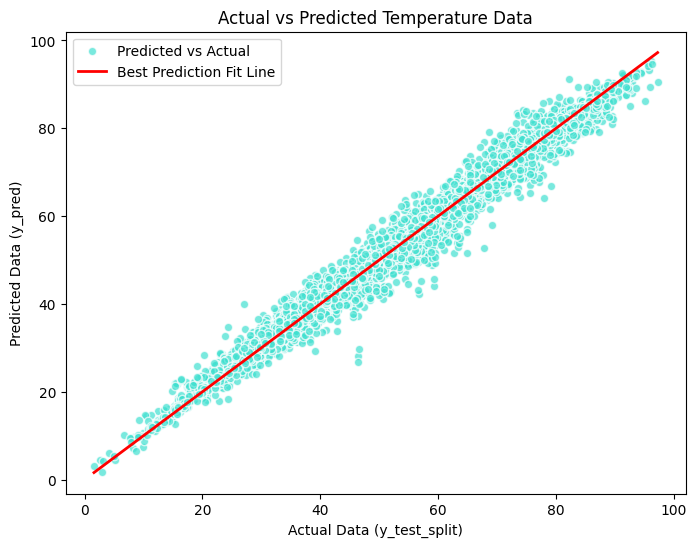

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='turquoise',edgecolors='white', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linewidth=2, label='Best Prediction Fit Line')  # y=x line
plt.xlabel('Actual Data (y_test_split)')
plt.ylabel('Predicted Data (y_pred)')
plt.title('Actual vs Predicted Temperature Data')
plt.legend()
plt.show()

### Deploy the Model on TabPy

In [20]:
from tabpy.tabpy_tools.client import Client

/Users/esha/Documents/Data Projects/datadev_hackathon2025/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [21]:
def temperature_prediction(_arg1):
    from datetime import datetime
    import pandas as pd

    # Ensure the 'time' column is in datetime format
    df = pd.DataFrame({'time': pd.to_datetime(_arg1)})
    
    # Extract year, month, day, and hour
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    
    # Drop the original 'time' column
    df_train = df.drop('time', axis=1)
    
    # Predict using the trained model
    y_pred = rfr.predict(df_train)
    
    # Return predictions as a list
    return y_pred.tolist()


In [22]:
client = Client('http://localhost:9004/')
client.deploy('forcast_temperature_new_test',temperature_prediction, description='Input the information of date and time, will forcast the temperture',override=True)